In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

# Get the data

In [2]:
# Read the csv and feed it into the variable xc
xc = pd.read_csv("morg-2014-emp.csv")

# Filter dataset for healthcare practitioners
xc = xc.loc[((xc["occ2012"] >= 3000) & (xc["occ2012"] <= 3540))]

C:\Users\iandr\AppData\Local\Temp\ipykernel_30500\1807558595.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.


In [17]:
# Create Variables
xc["female"] = (xc["sex"] == 2)
xc["w"] = xc["earnwke"] / xc["uhours"]
xc["lnw"] = np.log(xc["w"])
xc["agesq"] = np.power(xc["age"], 2)

In [48]:
xc['female'] = pd.to_numeric(xc['female'], errors='coerce')
xc['grade92'] = pd.to_numeric(xc['grade92'], errors='coerce')
xc['w'] = pd.to_numeric(xc['w'], errors='coerce')
xc = xc.dropna(subset=['female', 'grade92', 'w'])
xc["female"].value_counts()

female
1    7220
0    1988
Name: count, dtype: int64

# 1.: Show the unconditional gender gap

In [38]:
reg1 = smf.ols(formula="lnw~female", data=xc).fit(cov_type="HC1")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     60.71
Date:                Fri, 24 Nov 2023   Prob (F-statistic):           7.34e-15
Time:                        18:52:13   Log-Likelihood:                -8501.1
No. Observations:                9208   AIC:                         1.701e+04
Df Residuals:                    9206   BIC:                         1.702e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3329      0.015    215.323      0.000       3.303       3.363
female        -0.1320      0.017     -7.791      0.000      -0.165      -0.099
==============================================================================
Omnibus:                     8464.256   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1700709.478
Skew:                          -3.808   Prob(JB):                         0.00
Kurtosis:                      69.142   Cond. No.                         4.09
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

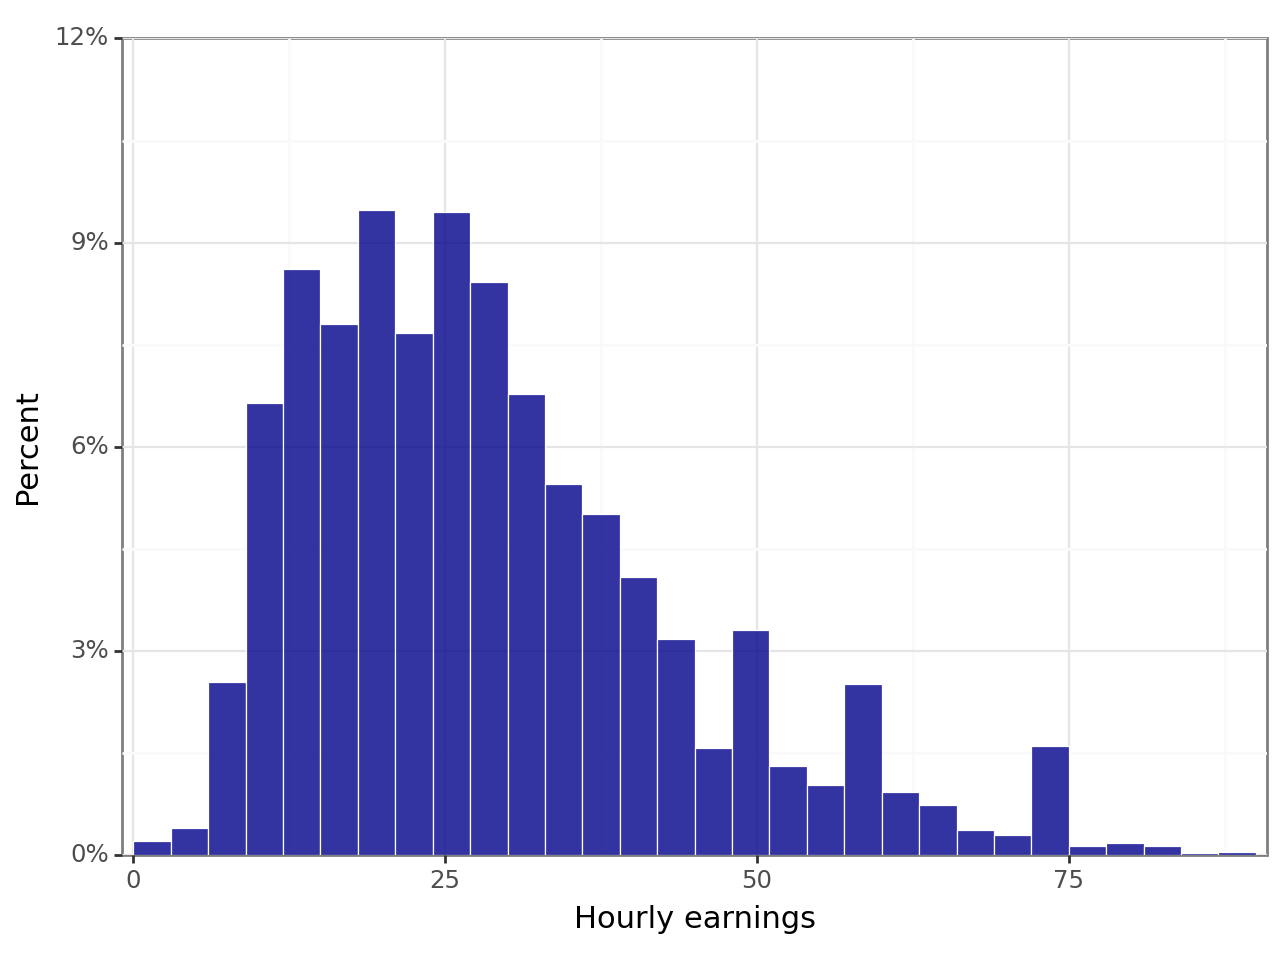

<Figure Size: (640 x 480)>

In [9]:
(
    ggplot(xc, aes(x="w", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Hourly earnings", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 90))
    + scale_y_continuous(
        labels=percent_format(), #mizani
        limits=(0, 0.12),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)


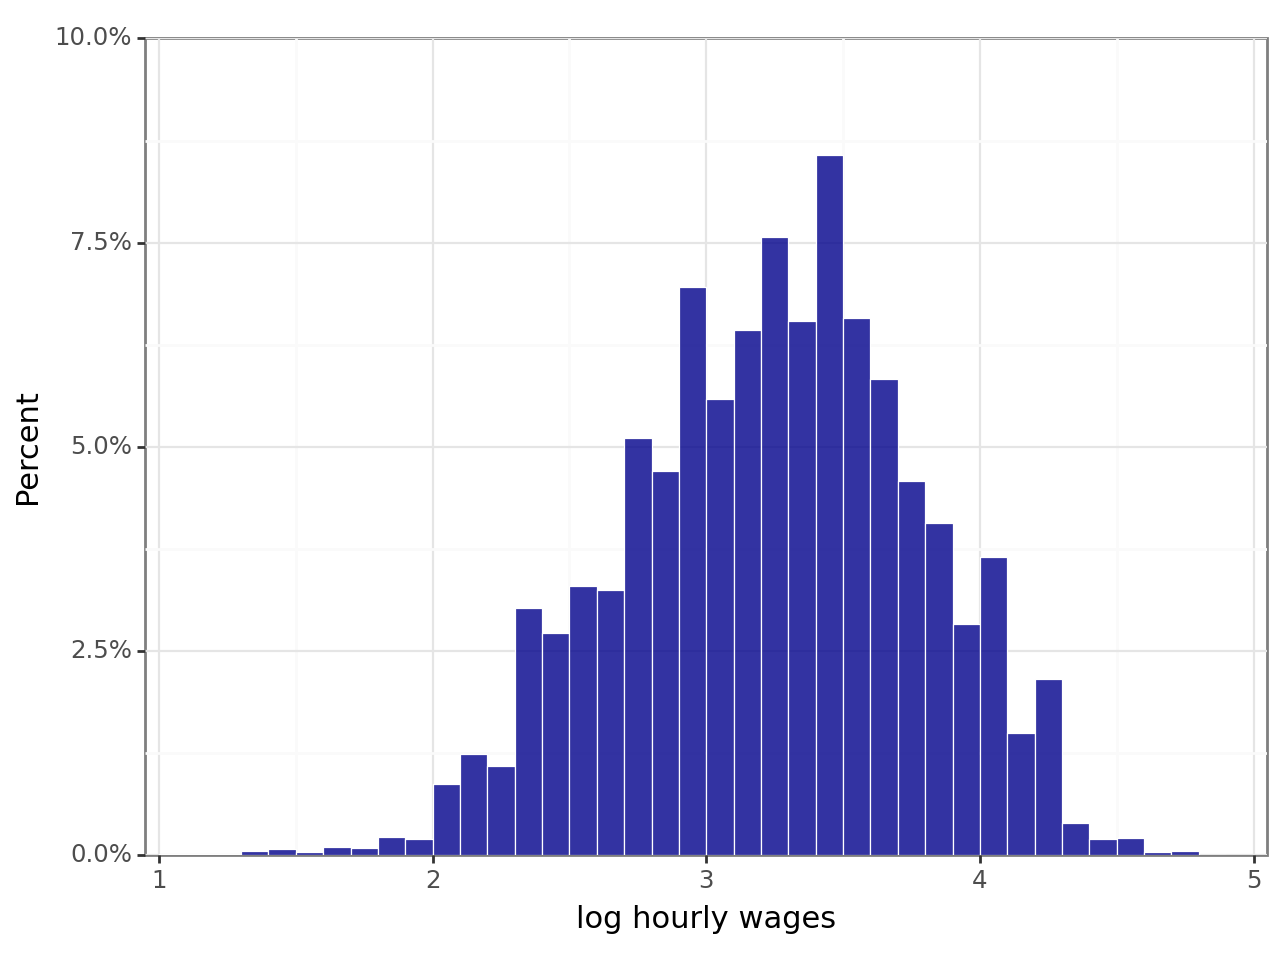

<Figure Size: (640 x 480)>

In [10]:
(
    ggplot(xc, aes(x="lnw", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="log hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)

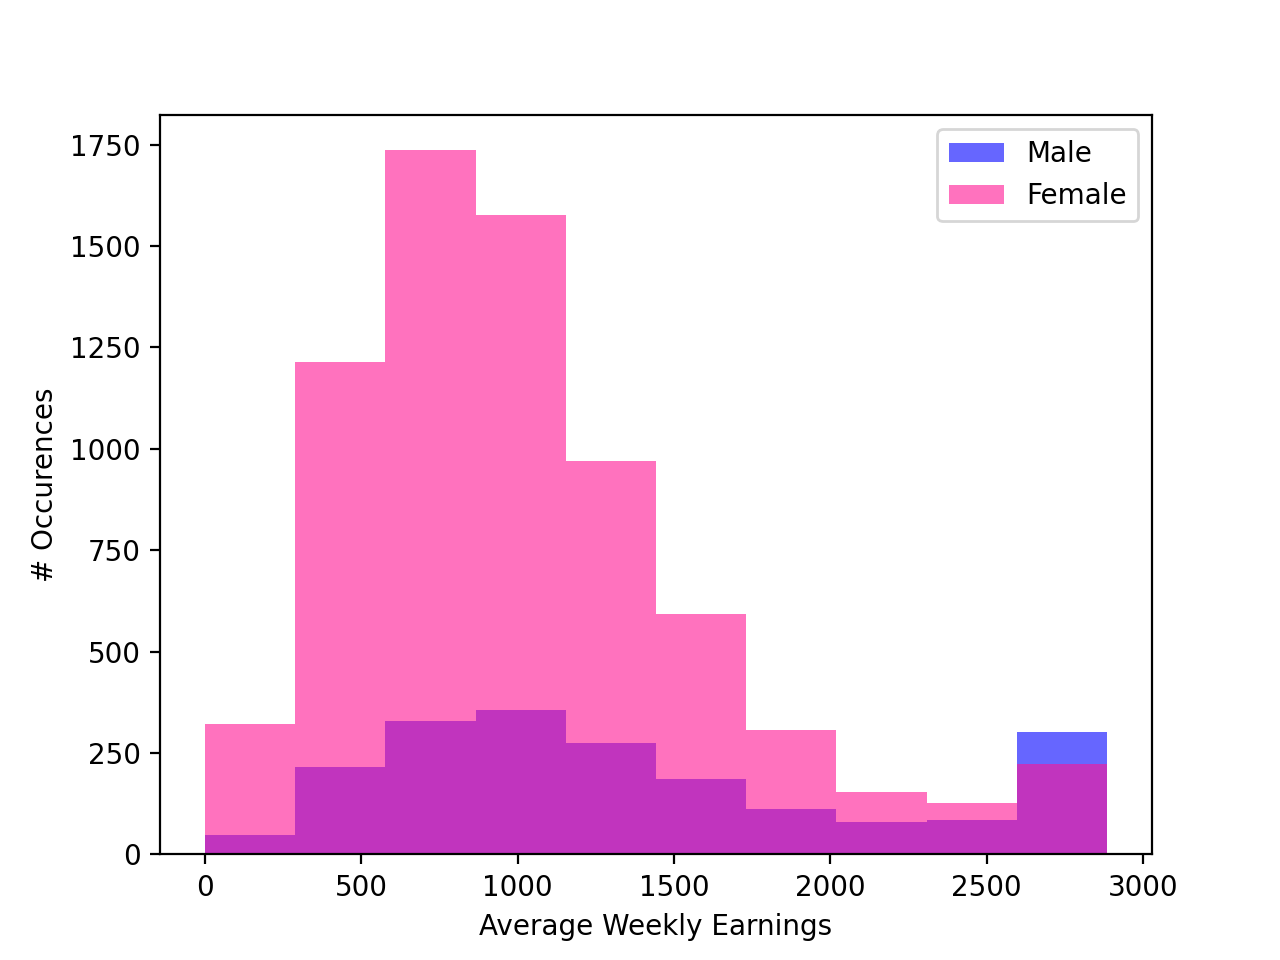

In [131]:
plt.hist(xc[xc["sex"] == 1]["earnwke"].reset_index(drop = True), alpha = 0.6, label = "Male", color = "blue")
plt.hist(xc[xc["sex"] == 2]["earnwke"].reset_index(drop = True), alpha = 0.6, label = "Female", color = "deeppink")
plt.xlabel("Average Weekly Earnings")
plt.ylabel("# Occurences")
plt.legend()
plt.show()

In [16]:
xc.loc[:, ["earnwke", "uhours", "w", "lnw"]].describe()

,earnwke,uhours,w,lnw
count,9208.000000,9208.000000,9208.000000,9208.000000
mean,1124.188752,38.541486,29.366761,3.229424
std,658.624137,9.863961,16.773557,0.611589
min,0.010000,1.000000,0.000200,-8.517193
25%,660.000000,36.000000,17.667500,2.871727
50%,980.000000,40.000000,26.000000,3.258097
75%,1420.200000,40.000000,37.393056,3.621485
max,2884.610000,99.000000,432.500000,6.069582


# 2. Show how the gender gap varies with the level of education. Consider several options to model the relationship.

## Level of Education

In [19]:
# Set variables

xc['BA_degree'] = (xc['grade92'] == 43).astype(int)
xc['MA_degree'] = (xc['grade92'] == 44).astype(int)
xc['Prof_degree'] = (xc['grade92'] == 45).astype(int)
xc['PhD_degree'] = (xc['grade92'] == 46).astype(int)

#Applied qualitative variables:

def EducationLvl(row):
    if row["grade92"] == 43:
        return "BA_degree"
    elif row["grade92"] == 44:
        return "MA_degree"
    elif row["grade92"] == 45:
        return "Prof_degree"
    elif row["grade92"] == 46:
        return "PhD_degree"
    else:
        return "Other"
    
xc["Education"] = xc.apply(EducationLvl, axis = 1)

In [50]:
(
    ggplot(data = xc) +
    aes(x = "female", y = "earnwke", fille ("female") +
    geom_boxplot() +
    coord_flip() +
    facet_wrap("Education") +
    theme_bw() +
    scale_fill_discrete(labels = ["Male", "Female"])) +
    labs(title = "Weekly earnings based on Sex (Grouped by Education)", x = "", y = "Weekly Earnings")
)

SyntaxError: positional argument follows keyword argument (1608735561.py, line 8)

In [22]:
xc["female"] = xc["female"].astype(int)  #from boolean to 0,1
reg6 = smf.ols(formula="lnw~female", data=xc).fit(cov_type="HC1") #unconditional
reg7 = smf.ols(formula="lnw~female+grade92", data=xc).fit(cov_type="HC1") #level of education enters linearly
reg8 = smf.ols(formula="lnw~female+grade92+BA_degree", data=xc).fit(cov_type="HC1") #add quadratic
reg9 = smf.ols(formula="lnw~female+grade92+BA_degree+MA_degree+Prof_degree", data=xc).fit(cov_type="HC1")
reg10 = smf.ols(formula="lnw~female+grade92+BA_degree+MA_degree+Prof_degree+PhD_degree", data=xc).fit(cov_type="HC1")#4-th order polynomial

In [23]:
stargazer = Stargazer([reg6, reg7, reg8, reg9, reg10])
stargazer.covariate_order(["female", "grade92", "BA_degree", "MA_degree", "Prof_degree", "PhD_degree", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

In [25]:
reg11 = smf.ols(formula="lnw~grade92", data=xc.query("female==1")).fit(cov_type="HC1")
reg12 = smf.ols(formula="lnw~grade92", data=xc.query("female==0")).fit(cov_type="HC1")
reg13 = smf.ols(formula="lnw~female+grade92+grade92*female", data=xc).fit(cov_type="HC1")

stargazer = Stargazer([reg11, reg12, reg13])
stargazer.covariate_order(["female", "grade92", "grade92:female", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant", "grade92:female": "female x grade92"})
stargazer.custom_columns(["Women", "Men", "All"], [1, 1, 1])
stargazer

In [26]:
reg14 = smf.ols(formula="lnw~grade92+BA_degree+MA_degree+Prof_degree+PhD_degree", data=xc.query("female==1")).fit(
    cov_type="HC1"
) #women
reg15 = smf.ols(formula="lnw~grade92+BA_degree+MA_degree+Prof_degree+PhD_degree", data=xc.query("female==0")).fit(
    cov_type="HC1"
) #men
reg16 = smf.ols(
    formula="lnw ~ grade92 + BA_degree + MA_degree + Prof_degree + PhD_degree + female + female*grade92 + female*BA_degree + female*MA_degree + female*Prof_degree + female*PhD_degree",
    data=xc,
).fit(cov_type="HC1")
 # interactions
    
Stargazer([reg14, reg15, reg16])

In [27]:
# PREDICTION AND GRAPH POLYNOMIAL
# male
data_m = xc.query("female==0")

pred = reg16.predict(data_m)

pred = reg16.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_m = data_m.reset_index(drop=True).join(pred)

data_m["CIup"] = data_m["fit"] + 2 * data_m["fit_se"]
data_m["CIlo"] = data_m["fit"] - 2 * data_m["fit_se"]

# female
data_f = xc.query("female==1")

pred = reg16.predict(data_f)

pred = reg16.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_f = data_f.reset_index(drop=True).join(pred)

data_f["CIup"] = data_f["fit"] + 2 * data_f["fit_se"]
data_f["CIlo"] = data_f["fit"] - 2 * data_f["fit_se"]

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 7 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 4 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 7 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 29 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 29 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 531 rows containing missing values.


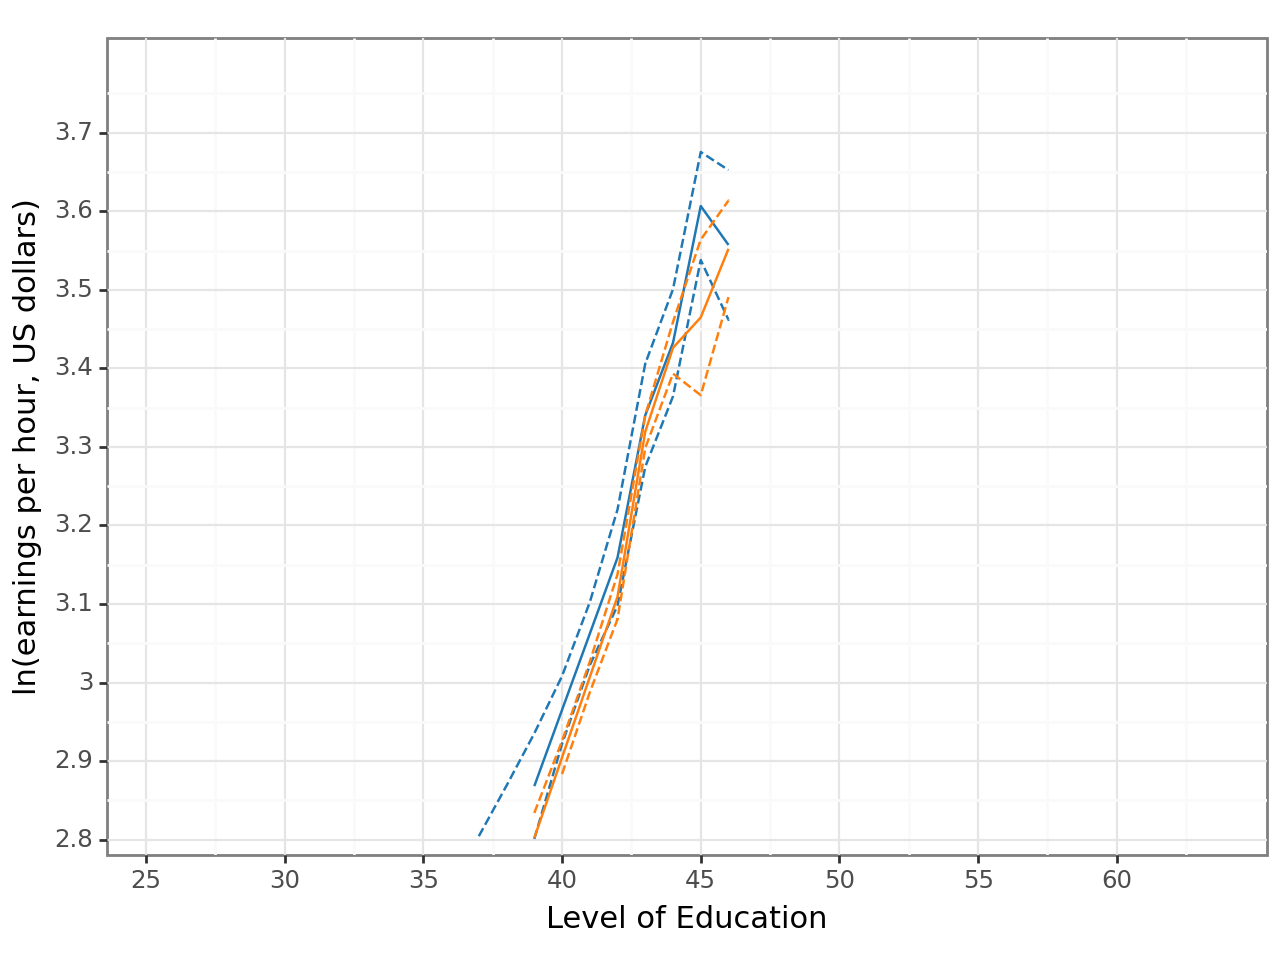

<Figure Size: (640 x 480)>

In [47]:
(
    ggplot(data_m, aes(x="grade92", y="fit", color="sex"))
    + geom_line(colour=color[0])
    + geom_line(data_m, aes(x="grade92", y="CIup"), colour=color[0], linetype="dashed")
    + geom_line(data_m, aes(x="grade92", y="CIlo"), colour=color[0], linetype="dashed")
    + geom_line(data_f, aes(x="grade92", y="fit"), colour=color[1])
    + geom_line(data_f, aes(x="grade92", y="CIup"), colour=color[1], linetype="dashed")
    + geom_line(data_f, aes(x="grade92", y="CIlo"), colour=color[1], linetype="dashed")
    + labs(x="Level of Education", y="ln(earnings per hour, US dollars)")
    + scale_color_manual(name='sex', values={ 'Male': color[0], 'Female': color[1] })
    + scale_x_continuous(expand=(0.01, 0.01), limits=(24, 65), breaks=np.arange(25, 65, 5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.8, 3.8), breaks=np.arange(2.8, 3.8, 0.1)
    )
    + theme_bw()
)